# Rt Live Model

Based on [Rt.live](https://Rt.live) model, original source code on [Github](https://github.com/rtcovidlive/covid-model).

Adapted for South Africa - Schalk van Heerden

Last update - 8 Aug 2020

In [1]:
%load_ext autoreload
%autoreload 2

from pip._internal import main
try:
    import pymc3 as pm
except:
    from pip._internal import main
    main(['install', 'pymc3'])
    import pymc3 as pm
        
import pandas as pd
import numpy as np
import arviz as az
from matplotlib import pyplot as plt
from covid.models.generative import GenerativeModel
from covid.data import summarize_inference_data
%config InlineBackend.figure_format = 'retina'

from covid.data import get_and_process_covidtracking_data, summarize_inference_data

## Setup
While testing, run US model first to baseline the latest model files. Set `us_run` to **True** For the latest stable model, checkout commit from 2 July 2020. 

For automated calculation run `rtlive-model-za.py`. Github Action `rtlive-model-za.yaml` will run automatically in on Github.

In [2]:
us_run = False

## Troubleshooting

1. Ensure that all modules are installed with `conda` from `requirements.txt`
1. How to solve Theano library warnings on some OS platforms: [SO](https://stackoverflow.com/questions/53423610/how-to-update-scan-cython-code-in-theano)

# Baseline model with US data

For the latest stable model, checkout commit from 2 July 2020.

## Fetch data and select the state's data

In [3]:
if us_run:
    df = get_and_process_covidtracking_data(run_date=pd.Timestamp.today()-pd.Timedelta(days=1))

In [4]:
if us_run:
    region = "OR"
    model_data = df.loc[region]
    model_data.tail()

## Create the model instance and sample

In [5]:
if us_run:
    gm = GenerativeModel(region, model_data)
    gm.sample()

## Summarize Model Output

In [6]:
result = pd.DataFrame()
if us_run:
    result = summarize_inference_data(gm.inference_data)
result.tail(10)

""


## Plot Model Output

In [7]:
def plot_results():
    fig, ax = plt.subplots(figsize=(10,5))
    result.test_adjusted_positive.plot(c="g", label="Test-adjusted")
    result.test_adjusted_positive_raw.plot(c="g", alpha=.5, label="Test-adjusted (raw)", style="--")
    result.infections.plot(c="b", label="Infections")
    gm.observed.positive.plot(c='r', alpha=.7, label="Reported Positives")
    fig.set_facecolor('w')
    ax.legend();
 
if us_run:
    plot_results()

In [8]:
def plot_rt():
    fig, ax = plt.subplots(figsize=(10,5))

    ax.set_title(f"{region} $R_t$")
    samples = gm.trace['r_t']
    x=result.index
    cmap = plt.get_cmap("Reds")
    percs = np.linspace(51, 99, 40)
    colors = (percs - np.min(percs)) / (np.max(percs) - np.min(percs))
    samples = samples.T

    result["median"].plot(c="k", ls='-')

    for i, p in enumerate(percs[::-1]):
        upper = np.percentile(samples, p, axis=1)
        lower = np.percentile(samples, 100-p, axis=1)
        color_val = colors[i]
        ax.fill_between(x, upper, lower, color=cmap(color_val), alpha=.8)

    ax.axhline(1.0, c="k", lw=1, linestyle="--")
    fig.set_facecolor('w')
 
if us_run:
    plot_rt()

# South African Results

## Download data

In [9]:
url = 'https://raw.githubusercontent.com/dsfsi/covid19za/master/data/covid19za_provincial_cumulative_timeline_confirmed.csv'
states_cases = pd.read_csv(url, parse_dates=['date'], dayfirst=True, index_col=0)
states_cases.tail()

,YYYYMMDD,EC,FS,GP,KZN,LP,MP,NC,NW,WC,UNKNOWN,total,source
date,,,,,,,,,,,,,
2020-09-19,20200919,88034.0,43776.0,217116.0,117569.0,14658.0,26389.0,14731.0,28025.0,109358.0,0.0,659656,https://sacoronavirus.co.za/2020/09/19/update-...
2020-09-20,20200920,88164.0,44037.0,217370.0,117743.0,14703.0,26479.0,15037.0,28171.0,109507.0,0.0,661211,https://sacoronavirus.co.za/2020/09/20/update-...
2020-09-21,20200921,88205.0,44291.0,217485.0,117833.0,14721.0,26525.0,15163.0,28187.0,109526.0,0.0,661936,https://sacoronavirus.co.za/2020/09/21/update-...
2020-09-22,20200922,88319.0,44616.0,217759.0,117972.0,14777.0,26612.0,15280.0,28331.0,109616.0,0.0,663282,https://twitter.com/nicd_sa/status/13084965257...
2020-09-23,20200923,88420.0,44943.0,218115.0,118174.0,14906.0,26712.0,15560.0,28528.0,109830.0,0.0,665188,https://twitter.com/nicd_sa/status/13088625370...


In [10]:
url = 'https://raw.githubusercontent.com/dsfsi/covid19za/master/data/covid19za_timeline_testing.csv'
states_tests = pd.read_csv(url, parse_dates=['date'], dayfirst=True, index_col=0)
states_tests.tail()

,YYYYMMDD,cumulative_tests,recovered,hospitalisation,critical_icu,ventilation,deaths,contacts_identified,contacts_traced,scanned_travellers,passengers_elevated_temperature,covid_suspected_criteria,source
date,,,,,,,,,,,,,
2020-09-18,20200918,4003590.0,586844,NaN,NaN,NaN,15857,NaN,NaN,NaN,NaN,NaN,https://sacoronavirus.co.za/2020/09/18/update-...
2020-09-19,20200919,4024659.0,589434,NaN,NaN,NaN,15940,NaN,NaN,NaN,NaN,NaN,https://sacoronavirus.co.za/2020/09/19/update-...
2020-09-20,20200920,4041543.0,590071,NaN,NaN,NaN,15953,NaN,NaN,NaN,NaN,NaN,https://sacoronavirus.co.za/2020/09/20/update-...
2020-09-21,20200921,4047723.0,591208,NaN,NaN,NaN,15992,NaN,NaN,NaN,NaN,NaN,https://sacoronavirus.co.za/2020/09/21/update-...
2020-09-22,20200922,4064117.0,592904,NaN,NaN,NaN,16118,NaN,NaN,NaN,NaN,NaN,https://sacoronavirus.co.za/2020/09/22/update-...


## Cleanup data

In [11]:
cases = pd.Series(states_cases['total'], index=states_cases.index, name='cases')
cases

date
2020-03-05         1
2020-03-07         2
2020-03-08         3
2020-03-09         7
2020-03-11        13
               ...  
2020-09-19    659656
2020-09-20    661211
2020-09-21    661936
2020-09-22    663282
2020-09-23    665188
Name: cases, Length: 201, dtype: int64

In [12]:
casezero = states_cases.index[0]
caselast = states_cases.index[-1]
casezero, caselast

(Timestamp('2020-03-05 00:00:00'), Timestamp('2020-09-23 00:00:00'))

In [13]:
idx = pd.date_range(casezero, caselast)

In [14]:
tests_all = pd.Series(states_tests['cumulative_tests'], index=states_tests.index, name='tests')
tests_all

date
2020-02-11         61.0
2020-02-13         67.0
2020-02-14         71.0
2020-02-19         95.0
2020-02-20        106.0
                ...    
2020-09-18    4003590.0
2020-09-19    4024659.0
2020-09-20    4041543.0
2020-09-21    4047723.0
2020-09-22    4064117.0
Name: tests, Length: 207, dtype: float64

In [15]:
tests = tests_all.loc[casezero:caselast]
tests

date
2020-03-06        200.0
2020-03-07        241.0
2020-03-11        645.0
2020-03-12        848.0
2020-03-13        924.0
                ...    
2020-09-18    4003590.0
2020-09-19    4024659.0
2020-09-20    4041543.0
2020-09-21    4047723.0
2020-09-22    4064117.0
Name: tests, Length: 198, dtype: float64

In [16]:
combined_model = pd.concat([cases, tests], axis=1)
combined_model

,cases,tests
date,,
2020-03-05,1.0,NaN
2020-03-06,NaN,200.0
2020-03-07,2.0,241.0
2020-03-08,3.0,NaN
2020-03-09,7.0,NaN
...,...,...
2020-09-19,659656.0,4024659.0
2020-09-20,661211.0,4041543.0
2020-09-21,661936.0,4047723.0


In [17]:
# Assume previous day testing result for missing data point
combined_model.loc[casezero,'tests'] = 163

In [18]:
# Reindex complete date range
filled_model = combined_model.reindex(idx, method='ffill')
filled_model

,cases,tests
2020-03-05,1.0,163.0
2020-03-06,NaN,200.0
2020-03-07,2.0,241.0
2020-03-08,3.0,NaN
2020-03-09,7.0,NaN
...,...,...
2020-09-19,659656.0,4024659.0
2020-09-20,661211.0,4041543.0
2020-09-21,661936.0,4047723.0
2020-09-22,663282.0,4064117.0


In [19]:
# Do a final clean up, assume previous day results for missing data points
final_filled_model = filled_model.ffill(axis=0)
final_filled_model

,cases,tests
2020-03-05,1.0,163.0
2020-03-06,1.0,200.0
2020-03-07,2.0,241.0
2020-03-08,3.0,241.0
2020-03-09,7.0,241.0
...,...,...
2020-09-19,659656.0,4024659.0
2020-09-20,661211.0,4041543.0
2020-09-21,661936.0,4047723.0
2020-09-22,663282.0,4064117.0


In [20]:
# Add delta columns for models
final_filled_model['positive'] = final_filled_model['cases'].diff()
final_filled_model['total'] = final_filled_model['tests'].diff()
final_filled_model

,cases,tests,positive,total
2020-03-05,1.0,163.0,NaN,NaN
2020-03-06,1.0,200.0,0.0,37.0
2020-03-07,2.0,241.0,1.0,41.0
2020-03-08,3.0,241.0,1.0,0.0
2020-03-09,7.0,241.0,4.0,0.0
...,...,...,...,...
2020-09-19,659656.0,4024659.0,2029.0,21069.0
2020-09-20,661211.0,4041543.0,1555.0,16884.0
2020-09-21,661936.0,4047723.0,725.0,6180.0
2020-09-22,663282.0,4064117.0,1346.0,16394.0


In [21]:
df_model = final_filled_model.iloc[1:]
df_model

,cases,tests,positive,total
2020-03-06,1.0,200.0,0.0,37.0
2020-03-07,2.0,241.0,1.0,41.0
2020-03-08,3.0,241.0,1.0,0.0
2020-03-09,7.0,241.0,4.0,0.0
2020-03-10,7.0,241.0,0.0,0.0
...,...,...,...,...
2020-09-19,659656.0,4024659.0,2029.0,21069.0
2020-09-20,661211.0,4041543.0,1555.0,16884.0
2020-09-21,661936.0,4047723.0,725.0,6180.0
2020-09-22,663282.0,4064117.0,1346.0,16394.0


## Calculate Rt

In [22]:
region = 'Total RSA'

In [23]:
gm = GenerativeModel(region, df_model)
gm.sample()

Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, seed, log_r_t]
Sampling 4 chains, 0 divergences: 100%|██████████| 3600/3600 [27:04<00:00,  2.22draws/s]


## Show results

In [24]:
result = summarize_inference_data(gm.inference_data)

100%|██████████| 800/800 [00:02<00:00, 306.69it/s]


In [25]:
result.tail(10)

,mean,median,lower_80,upper_80,infections,test_adjusted_positive,test_adjusted_positive_raw,positive,tests
date,,,,,,,,,
2020-09-14,0.990885,0.982637,0.816851,1.143907,2582.281846,2869.753031,2836.598936,956.0,10136.0
2020-09-15,0.992272,0.984079,0.806110,1.149385,2584.590849,2848.758999,2001.030247,772.0,11603.0
2020-09-16,0.995588,0.986558,0.796069,1.155700,2588.865413,2829.979526,2759.009607,1923.0,20962.0
2020-09-17,0.998161,0.994932,0.791676,1.163278,2595.496723,2813.311229,2863.011037,2128.0,22354.0
2020-09-18,0.995280,0.986903,0.800930,1.189505,2605.292687,2798.685621,3081.431351,2055.0,20057.0
2020-09-19,0.996266,0.981948,0.779720,1.170657,2618.527623,2786.010021,2896.308168,2029.0,21069.0
2020-09-20,0.997640,0.986578,0.776970,1.180627,2633.785702,2775.200064,2769.884724,1555.0,16884.0
2020-09-21,0.999667,0.984004,0.772651,1.187286,2650.699438,2766.211708,3528.224218,725.0,6180.0
2020-09-22,0.997495,0.986466,0.803603,1.227183,2670.383781,2759.035210,2469.259733,1346.0,16394.0


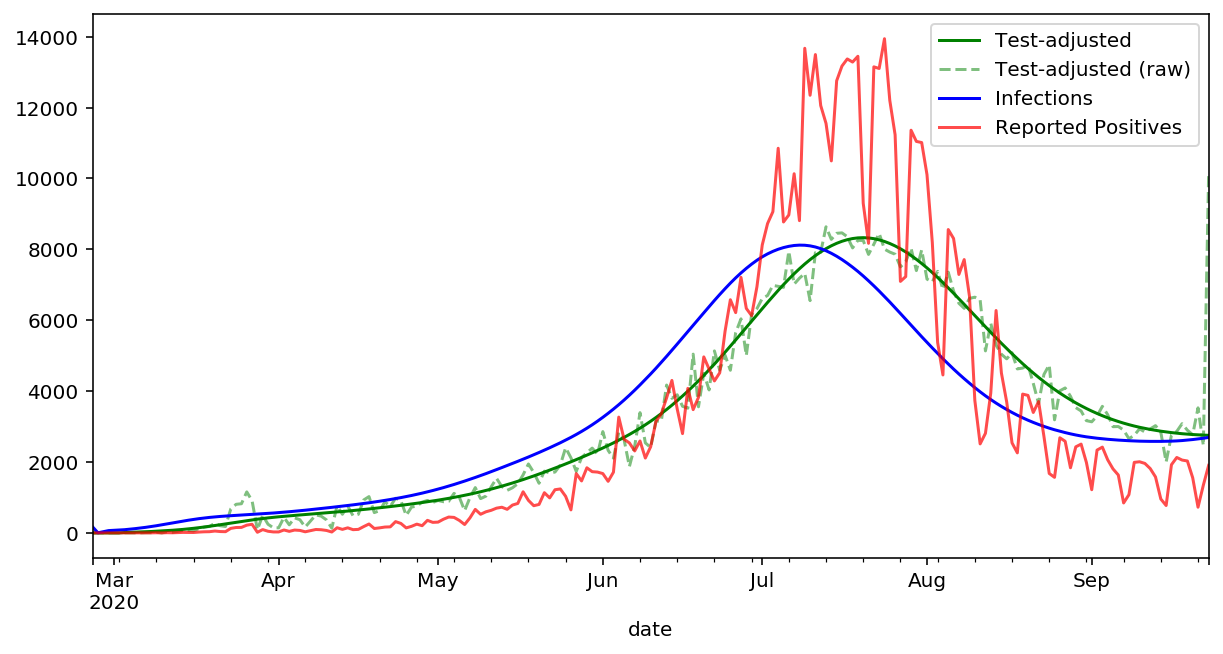

In [26]:
plot_results()

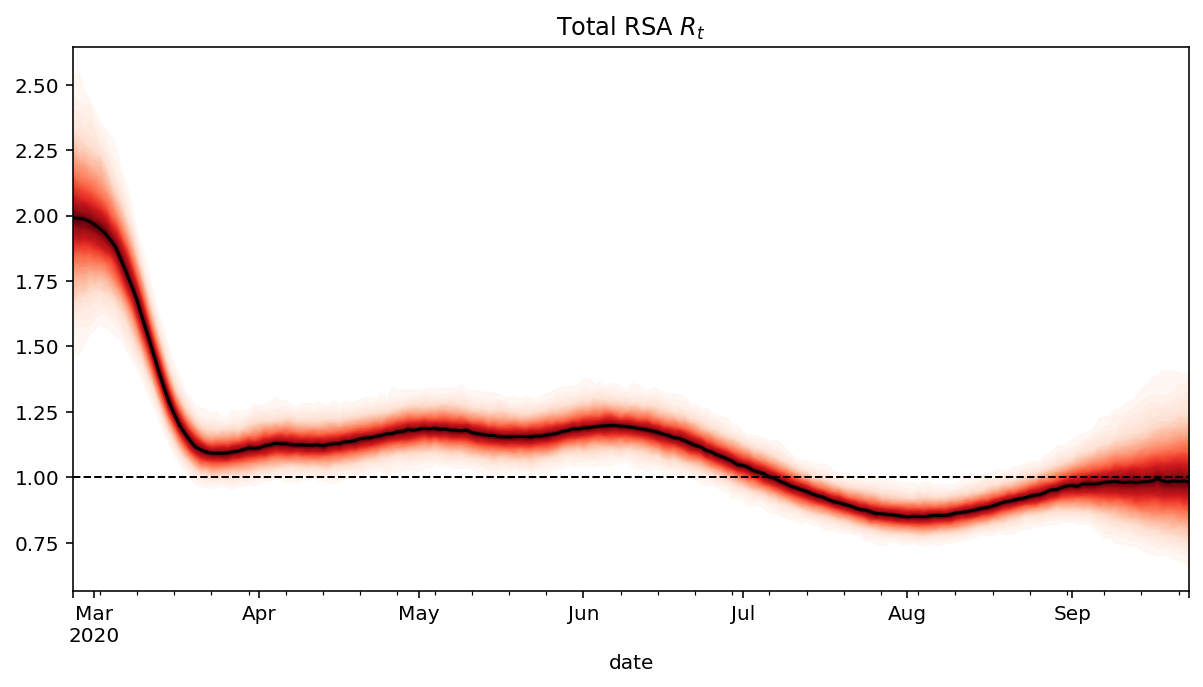

In [27]:
plot_rt()

In [28]:
export_results = result[['median','upper_80','lower_80','infections','test_adjusted_positive']]
export_results = export_results.rename(columns={'median':'Median','upper_80':'High_80','lower_80':'Low_80','infections':'Infections','test_adjusted_positive':'Adjusted_Postive'})
export_results.tail()

,Median,High_80,Low_80,Infections,Adjusted_Postive
date,,,,,
2020-09-19,0.981948,1.170657,0.779720,2618.527623,2786.010021
2020-09-20,0.986578,1.180627,0.776970,2633.785702,2775.200064
2020-09-21,0.984004,1.187286,0.772651,2650.699438,2766.211708
2020-09-22,0.986466,1.227183,0.803603,2670.383781,2759.035210
2020-09-23,0.982870,1.187805,0.757346,2693.608551,2753.714143


## Export results

In [29]:
export_results.to_csv('../../data/calc/calculated_rt_sa_mcmc.csv', float_format='%.3f')